本次以英雄联盟对局胜负预测任务为基础，要求实现决策树算法相关细节，加深对算法的理解，并了解做机器学习任务的大致流程。

### 任务介绍
英雄联盟（League of Legends，LoL）是一个多人在线竞技游戏，由拳头游戏（Riot Games）公司出品。在游戏中，每位玩家控制一位有独特技能的英雄，红蓝两支队伍各有五位玩家进行对战，目标是摧毁对方的基地水晶。水晶有多座防御塔保护，通常需要先摧毁一些防御塔再摧毁水晶。玩家所控制的英雄起初非常弱，需要不断击杀小兵、野怪和对方英雄来获得金币、经验。经验可以提升英雄等级和技能等级，金币可以用来购买装备提升攻击、防御等属性。对战过程中一般没有己方单位在附近的地点是没有视野的，即无法看到对面单位，双方可以通过使用守卫来监视某个地点，洞察对面走向、制定战术。
本数据集来自[Kaggle](https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min)，包含了9879场钻一到大师段位的单双排对局，对局双方几乎是同一水平。每条数据是前10分钟的对局情况，每支队伍有19个特征，红蓝双方共38个特征。这些特征包括英雄击杀、死亡，金钱、经验、等级情况等等。一局游戏一般会持续30至40分钟，但是实际前10分钟的局面很大程度上影响了之后胜负的走向。作为最成功的电子竞技游戏之一，对局数据、选手数据的量化与研究具有重要意义，可以启发游戏将来的发展和改进。

本任务是希望同学们依据注释的要求，对代码中空缺部分进行填写，**完成决策树模型的详细实现**，根据已有的对局前10分钟特征信息，预测最后获胜方是蓝色方还是红色方，了解执行一个**机器学习任务的大致流程**，并**提交代码和实验报告**。第一次作业也是一个机器学习小实验的例子，之后的作业可能不再提供预处理等流程代码，由同学们自己设计实验完成代码编写。

### 导入工具包
pandas是数据分析和处理常用的工具包，非常适合处理行列表格数据。numpy是数学运算工具包，支持高效的矩阵、向量运算。sklearn是机器学习常用工具包，包括了一些已经实现好的简单模型和一些常用数据处理方法、评价指标等函数。

In [21]:
import pandas as pd # 数据处理
import numpy as np # 数学运算
import matplotlib.pyplot as plt # 作图
import seaborn as sns # 作图
from sklearn.linear_model import LogisticRegression # 逻辑回归
from sklearn.preprocessing import MinMaxScaler # 归一化函数
from sklearn.model_selection import train_test_split, cross_validate # 划分数据集函数
from sklearn.metrics import accuracy_score # 准确率函数
RANDOM_SEED = 2020 # 固定随机种子


### 读入数据
假设数据文件放在`./data/`目录下，标准的csv文件可以用pandas里的`read_csv()`函数直接读入。文件共有40列，38个特征（红蓝方各19），1个标签列（blueWins），和一个对局标号（gameId）。对局标号不是标签也不是特征，可以舍去。

In [22]:
csv_data = 'E:/mini/mini one/dl-housework/high_diamond_ranked_10min.csv' # 数据路径
data_df = pd.read_csv(csv_data, sep=',') # 读入csv文件为pandas的DataFrame
data_df = data_df.drop(columns='gameId') # 舍去对局标号列

###  数据概览
对于一个机器学习问题，在拿到任务和数据后，首先需要观察数据的情况，比如我们可以通过`.iloc[0]`取出数据的第一行并输出。不难看出每个特征都存成了float64浮点数，该对局蓝色方开局10分钟有小优势。同时也可以发现有些特征列是重复冗余的，比如blueGoldDiff表示蓝色队金币优势，redGoldDiff表示红色方金币优势，这两个特征是完全对称的互为相反数。blueCSPerMin是蓝色方每分钟击杀小兵数，它乘10就是10分钟所有小兵击杀数blueTotalMinionsKilled。在之后的特征处理过程中可以考虑去除这些冗余特征。
另外，pandas有非常方便的`describe()`函数，可以直接通过DataFrame进行调用，可以展示每一列数据的一些统计信息，对数据分布情况有大致了解，比如blueKills蓝色方击杀英雄数在前十分钟的平均数是6.14、方差为2.93，中位数是6，百分之五十以上的对局中该特征在4-8之间，等等。

In [23]:
print(data_df.iloc[0]) # 输出第一行数据
data_df.describe() # 每列特征的简单统计信息
data_df.head(5)

blueWins                            0.0
blueWardsPlaced                    28.0
blueWardsDestroyed                  2.0
blueFirstBlood                      1.0
blueKills                           9.0
blueDeaths                          6.0
blueAssists                        11.0
blueEliteMonsters                   0.0
blueDragons                         0.0
blueHeralds                         0.0
blueTowersDestroyed                 0.0
blueTotalGold                   17210.0
blueAvgLevel                        6.6
blueTotalExperience             17039.0
blueTotalMinionsKilled            195.0
blueTotalJungleMinionsKilled       36.0
blueGoldDiff                      643.0
blueExperienceDiff                 -8.0
blueCSPerMin                       19.5
blueGoldPerMin                   1721.0
redWardsPlaced                     15.0
redWardsDestroyed                   6.0
redFirstBlood                       0.0
redKills                            6.0
redDeaths                           9.0


,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,0,28,2,1,9,6,11,0,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,0,12,1,0,5,5,5,0,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,0,15,0,0,7,11,4,1,1,0,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,0,43,1,0,4,5,5,1,0,1,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,0,75,4,0,6,6,6,0,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


### 增删特征
传统的机器学习模型大部分都是基于特征的，因此特征工程是机器学习中非常重要的一步。有时构造一个好的特征比改进一个模型带来的提升更大。这里简单展示一些特征处理的例子。首先，上面提到，特征列中有些特征信息是完全冗余的，会给模型带来不必要的计算量，可以去除。其次，相比于红蓝双方击杀、助攻的绝对值，可能双方击杀英雄的差值更能体现出当前对战的局势。因此，我们可以构造红蓝双方对应特征的差值。数据文件中已有的差值是金币差GoldDiff和经验差ExperienceDiff，实际上每个对应特征都可以构造这样的差值特征。

In [25]:
drop_features = ['blueGoldDiff', 'redGoldDiff', 
                 'blueExperienceDiff', 'redExperienceDiff', 
                 'blueCSPerMin', 'redCSPerMin', 
                 'blueGoldPerMin', 'redGoldPerMin'] # 需要舍去的特征列
df = data_df.drop(columns=drop_features) # 舍去特征列
info_names = [c[3:] for c in df.columns if c.startswith('red')] # 取出要作差值的特征名字（除去red前缀）
for info in info_names: # 对于每个特征名字
    df['br' + info] = df['blue' + info] - df['red' + info] # 构造一个新的特征，由蓝色特征减去红色特征，前缀为br
# 其中FirstBlood为首次击杀最多有一只队伍能获得，brFirstBlood=1为蓝，0为没有产生，-1为红
df = df.drop(columns=['blueFirstBlood', 'redFirstBlood']) # 原有的FirstBlood可删除
df.head(5)
df.describe()
print(df.shape)

(9879, 44)


### 特征离散化
决策树ID3算法一般是基于离散特征的，本例中存在很多连续的数值特征，例如队伍金币。直接应用该算法每个值当作一个该特征的一个取值可能造成严重的过拟合，因此需要对特征进行离散化，即将一定范围内的值映射成一个值，例如对用户年龄特征，将0-10映射到0，11-18映射到1，19-25映射到2，25-30映射到3，等等类似，然后在决策树构建时使用映射后的值计算信息增益。

***本小节要求实现特征离散化，请补全相关代码***

In [31]:
discrete_df = df.copy() # 先复制一份数据
# print(discrete_df)
discrete_df.to_csv('discrete_df.csv', index=False)
threshold = 10
for col in df.columns[1:]: # 遍历每一列特征，跳过标签列
    # 计算该列数据的差值
    col_diff = df[col].max() - df[col].min()

    # 如果差值小于阈值，跳过该列
    if col_diff < threshold:
        print(f"Skipping column {col} due to small difference ({col_diff})")
        continue

    # 否则进行离散化
    df[col + '_bins'] = pd.cut(df[col], bins=5, labels=False)

# 输出处理后的 DataFrame
print(df.head())

(9879, 71)
(9879, 71)


### 数据集准备
构建机器学习模型前要构建训练和测试的数据集。在本例中首先需要分开标签和特征，标签是不能作为模型的输入特征的，就好比作业和试卷答案不能在做题和考试前就告诉学生。测试一个模型在一个任务上的效果至少需要训练集和测试集，训练集用来训练模型的参数，好比学生做作业获得知识，测试集用来测试模型效果，好比期末考试考察学生学习情况。测试集的样本不应该出现在训练集中，否则会造成模型效果估计偏高，好比考试时出的题如果是作业题中出现过的，会造成考试分数不能准确衡量学生的学习情况，估计值偏高。划分训练集和测试集有多种方法，下面首先介绍的是随机取一部分如20%作测试集，剩下作训练集。sklearn提供了相关工具函数`train_test_split`。sklearn的输入输出一般为numpy的array矩阵，需要先将pandas的DataFrame取出为numpy的array矩阵。

In [32]:
all_y = discrete_df['blueWins'].values # 所有标签数据
feature_names = discrete_df.columns[1:] # 所有特征的名称
all_x = discrete_df[feature_names].values # 所有原始特征值，pandas的DataFrame.values取出为numpy的array矩阵

# 划分训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.2, random_state=RANDOM_SEED)
all_y.shape, all_x.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape # 输出数据行列信息

((9879,), (9879, 70), (7903, 70), (1976, 70), (7903,), (1976,))

In [33]:
# 模型训练和测试
LR = LogisticRegression(random_state=RANDOM_SEED, verbose=1, max_iter=1000) # 初始化逻辑回归模型
LR.fit(x_train, y_train) # 在训练集上训练
p_test = LR.predict(x_test) # 在测试集上预测，获得预测值
print(p_test) # 输出预测值
test_acc = accuracy_score(p_test, y_test) # 将测试预测值与测试集标签对比获得准确率
print('accuracy: {:.4}'.format(test_acc)) # 输出准确率


[0 1 0 ... 0 1 1]
accuracy: 0.7353


In [34]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators = 10, oob_score=True)
RF.fit(x_train, y_train)
p_test = RF.predict(x_test) # 在测试集上预测，获得预测值
print(p_test) # 输出预测值
test_acc = accuracy_score(p_test, y_test) # 将测试预测值与测试集标签对比获得准确率
print('accuracy: {:.4}'.format(test_acc)) # 输出准确率

[0 1 0 ... 0 1 1]
accuracy: 0.6852


d:\Anaconda\envs\ml\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


In [35]:
from sklearn.svm import SVC
model = SVC(C = 1,kernel='linear')
model.fit(x_train, y_train)
p_test = model.predict(x_test) # 在测试集上预测，获得预测值
print(p_test) # 输出预测值
test_acc = accuracy_score(p_test, y_test) # 将测试预测值与测试集标签对比获得准确率
print('accuracy: {:.4}'.format(test_acc))

[0 1 0 ... 0 1 1]
accuracy: 0.7303


In [36]:
#交叉验证
model = SVC(C = 1,kernel='linear') # 定义逻辑回归模型
scores = cross_validate(model, all_x, all_y, cv=5, scoring=('accuracy'), return_train_score=True) # 5折交叉验证
print(scores) # 交叉验证的结果，是个python的dict，存有训练时间fit_time、测试时间score_time，测试准确率test_score，训练准确率train_score
print('average accuracy: {:.4f}'.format(np.mean(scores['test_score']))) # 输出多折的测试准确率均值


{'fit_time': array([44.33071303, 56.52677989, 46.12846136, 47.71538973, 46.56432939]), 'score_time': array([0.13482809, 0.14475942, 0.13749194, 0.15006566, 0.1272316 ]), 'test_score': array([0.74240891, 0.73481781, 0.7257085 , 0.73582996, 0.73316456]), 'train_score': array([0.7308617 , 0.73491079, 0.73491079, 0.73187397, 0.7346913 ])}
average accuracy: 0.7344


In [37]:
# 模型参数
LR.fit(x_train, y_train) # 训练模型
print(LR.classes_.shape, LR.classes_) # 类别个数
print(LR.n_iter_.shape, LR.n_iter_) # 训练执行轮次
print(LR.coef_.shape, LR.coef_) # 特征权重
print(LR.intercept_.shape, LR.intercept_) # 分类截距


(2,) [0 1]
(1,) [486]
(1, 70) [[-2.16650684e-03  9.14035244e-03  9.51349822e-03 -4.53054577e-03
  -5.85096253e-03  4.61924509e-02  4.08816212e-02  5.31082973e-03
  -3.21609690e-03  1.19801038e-04 -4.39235160e-04  6.61875958e-05
  -8.41947679e-04  4.23242643e-03 -2.55635482e-03 -3.01736872e-03
  -4.53054577e-03  9.51349822e-03 -4.75013176e-03 -4.49219265e-02
  -4.11807012e-02 -3.74122528e-03  4.17762089e-03 -1.14014914e-04
  -7.35112657e-04 -7.08039809e-05 -4.24331038e-04  2.23272912e-03
   3.89847978e-04  1.21577212e-02  1.36176428e-02  1.40440440e-02
  -1.40440440e-02 -1.10083077e-03  9.11143774e-02  8.20623224e-02
   9.05205501e-03 -7.39371779e-03  2.33815953e-04  2.95877496e-04
   1.36991576e-04 -4.17616640e-04  1.99969732e-03  8.22642092e-04
   2.44139357e-03 -1.87047946e-03  4.02663467e-04 -2.81715737e-03
   2.50620180e-03 -1.20881959e-03  5.69056554e-03 -5.23115744e-04
  -3.51269827e-04  4.61227942e-03  4.02663467e-04 -1.87047946e-03
  -5.45360587e-03 -1.14303422e-03  5.47771876e

d:\Anaconda\envs\ml\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\envs\ml\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\envs\ml\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: >

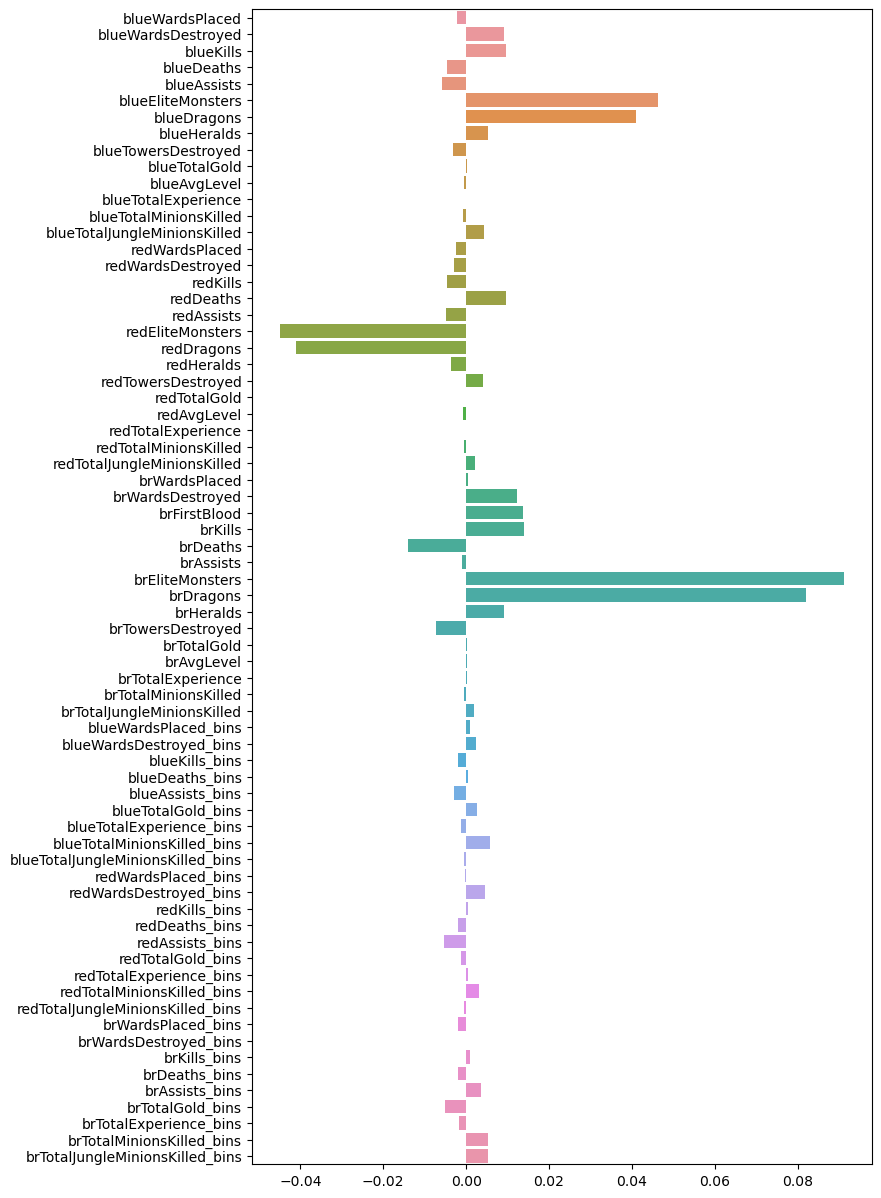

In [38]:
plt.figure(figsize=(8,15))
sns.barplot(x=LR.coef_[0], y=df.columns[1:])


### 总结
特征离散化：pd.cut 函数用于将每一列的数据划分为5个离散化的区间，并创建一个新的列，添加到原始数据 DataFrame 中。如果某一列的数据差值小于 threshold=10，则会跳过该列。

模型选择：分别使用逻辑回归，随机森林，支持向量机，交叉验证等模型训练预测模型，由预测准确性可得，逻辑回归的性能更好，因此选择逻辑回归作为预测模型

特征重要性分析：brEliteMonsters和brDragons与目标的相关程度最大